# Plot AEW tracks during campaign

Plot climatological AEW tracks, actual tracks, and Meteor ship track, between August 16 and September 24, through 4S-20N,20W to 60W [or August 10-September 30 for whole campaign]

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
import pandas as pd
import cftime
import geopy.distance
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sn
import cartopy

In [17]:
# Define constants
#years = np.arange(1979, 2024)  # Year range for climatology 1979 to 2023 inclusive
years = np.arange(1981, 2024)
#years = np.arange(1991, 2021)
lat1, lat2 = -2, 22.1             # Latitude range
lon1, lon2 = -62.1, -9.9            # Longitude range
#lat1, lat2 = -0.1, 20.1             # Latitude range
#lon1, lon2 = -60.1, -19.9            # Longitude range
gridsize = 1                     # Grid size for track density
mon1 = 8
day1 = 10
mon2 = 9
day2 = 30

Ship data

In [3]:
# Load ship track data from a NetCDF file using xarray
ds = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')

# Extract variables directly from xarray dataset
shipLON = ds['lon'].values
shipLAT = ds['lat'].values
shipTIME = ds['time'].values

ds.close()

AEW Climatology

In [4]:
#Load historical AEW tracks to generate a climatology

#Load one file to get lat/lon arrays
#ds = xr.open_dataset('/Users/awing/Dropbox/AEWtracks/ERA5_AEW_TRACKS/AEW_tracks_post_processed_year_1986.nc')
ds = xr.open_dataset('/Users/awing/Dropbox/AEWtracks/ERA5_WITH_EPAC/ERA5_AEW_tracks_with_basins_1986.nc')
lat = ds['latitude'].values
lon = ds['longitude'].values

ds.close()

In [18]:
AEWcount = np.zeros(len(years))  # Count of AEWs per year
AEWlon_subset = np.full((162, 612, len(years)), np.nan)  # Initialize as NaN arrays
AEWlat_subset = np.full((162, 612, len(years)), np.nan)
dates_subset = np.full((612, len(years)), None)  # Initialize as None arrays
start_date = cftime.DatetimeGregorian(1900, 1, 1, 0, 0, 0)  # Use cftime for high capacity date handling

# Loop over each year
for i, year in enumerate(years):
    # Define file path (adjust with actual file path structure)
    #fname = f'/Users/awing/Dropbox/AEWtracks/ERA5_AEW_TRACKS/AEW_tracks_post_processed_year_{year}.nc' #Quinton's tracks over Atlantic
    fname = f'/Users/awing/Dropbox/AEWtracks/ERA5_WITH_EPAC/ERA5_AEW_tracks_with_basins_{year}.nc' #Quinton's updated tracks over ATL & EPAC

    # Open the NetCDF file for the current year
    with xr.open_dataset(fname, decode_times=False) as ds:
        # Load latitude, longitude, and time data
        AEW_lon = ds['AEW_lon_smooth'].values  # System x Time
        AEW_lat = ds['AEW_lat_smooth'].values
        time = ds['time'].values  # Time in hours since 1900-01-01 00:00:00.0

        # Get dimensions
        nsystem, ntime = AEW_lat.shape

        # Convert time to datetime using cftime
        dates = [start_date + pd.Timedelta(hours=int(t)) for t in time]
        month_day = [(d.month, d.day) for d in dates]  # Extract month and day

        # Filter indices within the specified date range
        itimecheck = [k for k, (m, d) in enumerate(month_day)
                      if (m == mon1 and d >= day1) or (m == mon2 and d <= day2)]

        # Subset the AEW latitude and longitude data
        AEWlon = AEW_lon[:,itimecheck]
        AEWlat = AEW_lat[:,itimecheck]
        AEWlon_subset[:nsystem, itimecheck, i] = AEWlon
        AEWlat_subset[:nsystem, itimecheck, i] = AEWlat
        dates_subset[:ntime, i] = dates

        # Loop over each system to check if it falls within the region
        for j in range(nsystem):
            # Identify points within the specified region
            iregioncheck = np.where((AEWlat[j, :] >= lat1) & (AEWlat[j, :] <= lat2) &
                                    (AEWlon[j, :] >= lon1) & (AEWlon[j, :] <= lon2))[0]

            # Increment count if any points are within the region
            if iregioncheck.size > 0:
                AEWcount[i] += 1

# Print the AEW count per year for verification
print("AEW count per year:", AEWcount)

#Climatological average AEWcount for that time period/region (average AEWcount over all years)
climoAEWcount = np.mean(AEWcount)
print("climoAEWcount:", climoAEWcount)

ds.close()

AEW count per year: [25. 20. 21. 23. 21. 22. 28. 27. 23. 20. 26. 29. 33. 24. 22. 25. 21. 25.
 28. 25. 23. 24. 23. 22. 21. 23. 20. 26. 20. 29. 24. 23. 22. 21. 25. 27.
 27. 22. 23. 25. 25. 28. 23.]
climoAEWcount: 24.046511627906977


In [19]:
#Track density calculation
# grid
Xp = np.arange(lon1, lon2+1, gridsize)  # Longitude grid
Yp = np.arange(lat2, lat1-1, -gridsize)      # Latitude grid in reverse order
lx = len(Xp)
ly = len(Yp)

# Initialize track density array
trden = np.zeros((ly, lx, len(years)))

# Loop over all years, all storms, all points along tracks
for i in range(162):  # systems
    for j in range(612):  # track points
        for k in range(len(years)):  # years
            # If the storm can be assigned to 2 grid boxes, choose the nearest one
            ix = np.where((Xp >= AEWlon_subset[i, j, k] - gridsize / 2) &
                          (Xp < AEWlon_subset[i, j, k] + gridsize / 2))[0]
            if len(ix) > 1:
                diff = Xp[ix] - AEWlon_subset[i, j, k]
                ixv = ix[np.argmin(np.abs(diff))]
            else:
                ixv = ix[0] if ix.size > 0 else None

            iy = np.where((Yp >= AEWlat_subset[i, j, k] - gridsize / 2) &
                          (Yp < AEWlat_subset[i, j, k] + gridsize / 2))[0]
            if len(iy) > 1:
                diff = Yp[iy] - AEWlat_subset[i, j, k]
                iyv = iy[np.argmin(np.abs(diff))]
            else:
                iyv = iy[0] if iy.size > 0 else None

            # Update the track density if ixv and iyv are valid
            if ixv is not None and iyv is not None:
                trden[iyv, ixv, k] += 0.25  # Because tracks given four times per day


# Calculate the average track density over all years
trden_avg = np.mean(trden, axis=2)

# Make the average track density NaN where it is zero
trden_avg = np.where(trden_avg == 0, np.nan, trden_avg)

AEW tracks during BOWTIE

In [20]:
#Open the file with the AEW tracks from August-September 2024
#ds = xr.open_dataset('./AEWtracking/AEW_tracks_BOWTIE_post_processed.nc',decode_times=False) #mine
#ds = xr.open_dataset('/Users/awing/Dropbox/AEWtracks/tracks_2024/ERA5_AEW_tracks_with_basins_2024.nc',decode_times=False) #Quinton's updated tracks over ATL & EPAC
ds = xr.open_dataset('/Users/awing/Dropbox/AEWtracks/ERA5_WITH_EPAC/ERA5_AEW_tracks_with_basins_2024.nc',decode_times=False) #Quinton's updated tracks over ATL & EPAC

AEW_lon2024 = ds['AEW_lon_smooth'].values  # System x Time
AEW_lat2024 = ds['AEW_lat_smooth'].values
time2024 = ds['time'].values  # Time in seconds since 1970-01-01 00:00:00.0
start_date2024 = cftime.DatetimeGregorian(1970, 1, 1, 0, 0, 0)  # Use cftime for high capacity date handling

# Get dimensions
nsystem2024, ntime2024 = AEW_lat2024.shape

AEWcount2024 = 0  # Iniitialize Count of AEWs in 2024

# Convert time to datetime using cftime
dates2024 = [start_date2024 + pd.Timedelta(seconds=int(t)) for t in time2024]
month_day2024 = [(d.month, d.day) for d in dates2024]  # Extract month and day

# Filter indices within the specified date range (August 16 - September 24)
itimecheck2024 = [k for k, (m, d) in enumerate(month_day2024)
               if (m == mon1 and d >= day1) or (m == mon2 and d <= day2)]

# Subset the AEW latitude and longitude data
AEWlon2024 = AEW_lon2024[:,itimecheck2024]
AEWlat2024 = AEW_lat2024[:,itimecheck2024]

# Loop over each system to check if it falls within the region
for j in range(nsystem2024):
            # Identify points within the specified region
            iregioncheck = np.where((AEWlat2024[j, :] >= lat1) & (AEWlat2024[j, :] <= lat2) &
                                    (AEWlon2024[j, :] >= lon1) & (AEWlon2024[j, :] <= lon2))[0]

            # Increment count if any points are within the region
            if iregioncheck.size > 0:
                AEWcount2024 += 1

print("AEW count in 2024:", AEWcount2024)

AEW count in 2024: 24


In [16]:
#Open the file with the AEW tracks from August-September 2024
#ds = xr.open_dataset('./AEWtracking/AEW_tracks_BOWTIE_post_processed.nc',decode_times=False) #mine
ds = xr.open_dataset('/Users/awing/Dropbox/AEWtracks/tracks_2024/ERA5_AEW_tracks_with_basins_2024.nc',decode_times=False) #Quinton's

AEW_lon2024q = ds['AEW_lon_smooth'].values  # System x Time
AEW_lat2024q = ds['AEW_lat_smooth'].values
time2024q = ds['time'].values  # Time in seconds since 1970-01-01 00:00:00.0
start_date2024q = cftime.DatetimeGregorian(1970, 1, 1, 0, 0, 0)  # Use cftime for high capacity date handling

# Get dimensions
nsystem2024q, ntime2024q = AEW_lat2024q.shape

AEWcount2024q = 0  # Iniitialize Count of AEWs in 2024

# Convert time to datetime using cftime
dates2024q = [start_date2024q + pd.Timedelta(seconds=int(t)) for t in time2024q]
month_day2024q = [(d.month, d.day) for d in dates2024q]  # Extract month and day

# Filter indices within the specified date range (August 16 - September 24)
itimecheck2024q = [k for k, (m, d) in enumerate(month_day2024q)
               if (m == mon1 and d >= day1) or (m == mon2 and d <= day2)]

# Subset the AEW latitude and longitude data
AEWlon2024q = AEW_lon2024q[:,itimecheck2024q]
AEWlat2024q = AEW_lat2024q[:,itimecheck2024q]

# Loop over each system to check if it falls within the region
for j in range(nsystem2024q):
            # Identify points within the specified region
            iregioncheck = np.where((AEWlat2024q[j, :] >= lat1) & (AEWlat2024q[j, :] <= lat2) &
                                    (AEWlon2024q[j, :] >= lon1) & (AEWlon2024q[j, :] <= lon2))[0]

            # Increment count if any points are within the region
            if iregioncheck.size > 0:
                AEWcount2024q += 1

print("AEW count in 2024:", AEWcount2024q)

AEW count in 2024: 30


In [ ]:
# Add ERA-5 mean CWV
era5 = xr.open_dataset('../../data/ERA5_hrly_OLR_Prec_PW_20240809.nc')

# average ERA-5 CWV over time period of campaign
start_time = np.datetime64('2024-08-16T00:00:00')
index_start = np.where(pd.to_datetime(era5.valid_time) == start_time)[0]
index_start = int(index_start[0])

end_time = np.datetime64('2024-09-24T00:00:00')
index_end = np.where(pd.to_datetime(era5.valid_time) == end_time)[0]
index_end = int(index_end[0])

tcwv_mean = era5.tcwv[index_start:index_end].mean(dim='valid_time')

Text(0.5, 1.0, 'AEW Tracks: 08-10 - 09-30, 2024')

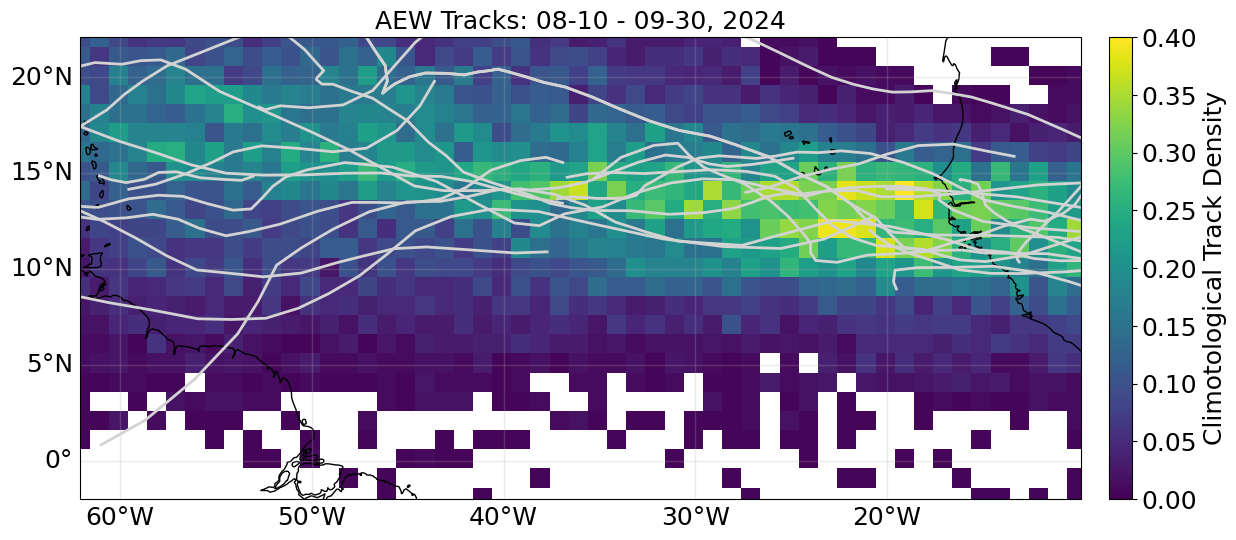

In [21]:
plt.figure(figsize = (18, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',linewidth=1,alpha=1)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

#plot the track density
#cax = ax.imshow(trden_avg, extent=(Xp[0], Xp[-1], Yp[0], Yp[-1]), aspect='auto', cmap='turbo', origin='lower', vmin=0, vmax=0.4)
plt.pcolormesh(Xp, Yp, trden_avg, vmin=0, vmax=0.40)

# Add colorbar
cbar=plt.colorbar(orientation='vertical', pad=0.02)
cbar.set_label('Climotological Track Density',fontsize=18)  #add a label to the colorbar

#plot the AEW tracks in 2024
nAEW2024, ntimeAEW2024 = AEWlat2024.shape
for i in range(nAEW2024):
    ax.plot(AEWlon2024[i, :], AEWlat2024[i, :], 'lightgray', linewidth=2)

##plot mean CWV 48 mm contour from era5
#plt.contour(era5.longitude.values,era5.latitude.values, tcwv_mean,levels = [48],colors = 'r',linewidth = 1)

#plot the ship track
#ax.plot(shipLON, shipLAT, 'k', linewidth=2)

#Set the plot limits and title
cbar.ax.tick_params(labelsize=18)
ax.set_xlim(lon1, lon2)
ax.set_ylim(lat1, lat2)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'AEW Tracks: {mon1:02d}-{day1:02d} - {mon2:02d}-{day2:02d}, 2024', fontsize=18)   

In [ ]:
plt.figure(figsize = (18, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',linewidth=1,alpha=1)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

#plot the AEW tracks in 2024
nAEW2024, ntimeAEW2024 = AEWlat2024.shape
for i in range(nAEW2024):
    ax.plot(AEWlon2024[i, :], AEWlat2024[i, :], 'gray', linewidth=2)

nAEW2024q, ntimeAEW2024q = AEWlat2024q.shape
for i in range(nAEW2024q):
    ax.plot(AEWlon2024q[i, :], AEWlat2024q[i, :], 'orange', linewidth=1)

#Set the plot limits and title
cbar.ax.tick_params(labelsize=18)
ax.set_xlim(lon1, lon2)
ax.set_ylim(lat1, lat2)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'AEW Tracks: {mon1:02d}-{day1:02d} - {mon2:02d}-{day2:02d}, 2024', fontsize=18)   

<>:49: SyntaxWarning: invalid escape sequence '\c'
<>:49: SyntaxWarning: invalid escape sequence '\c'
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_89163/837362703.py:49: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('AEW Latitude at Longitude = 18$^\circ$W')


Text(0.5, 1.0, 'AEW Latitude at Longitude = 18$^\\circ$W')

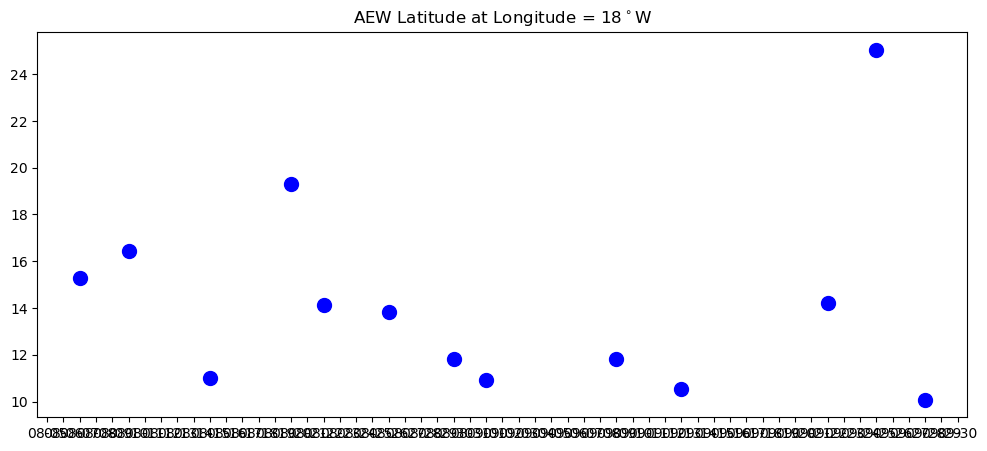

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
#make month day array from august 1 to september 30
date_range = pd.date_range(start="2024-08-01", end="2024-09-30")
date18_md_reg = [f"{d.month:02d}-{d.day:02d}" for d in date_range]
#make lat18_reg_2024 that is same size as date18_md_reg
lat18_2024_reg = np.full(np.size(date18_md_reg), np.nan)

nAEW2024, ntimeAEW2024 = AEW_lat2024.shape
lat18_2024 = np.full(nAEW2024, np.nan)  # Initialize array to hold latitudes at lon = -18
date18_2024 = [None] * nAEW2024
for i in range(nAEW2024):
    # Interpolate AEW latitude to a longitude of -18
    mask = ~np.isnan(AEW_lon2024[i, :]) & ~np.isnan(AEW_lat2024[i, :])
    lon_masked = AEW_lon2024[i, :][mask]
    lat_masked = AEW_lat2024[i, :][mask]
    dates2024_arr = np.array(dates2024)
    dates_masked = dates2024_arr[mask]

    # Sort by longitude increasing
    sort_idx = np.argsort(lon_masked)
    lon_sorted = lon_masked[sort_idx]
    lat_sorted = lat_masked[sort_idx]
    date_sorted = dates_masked[sort_idx]

    # Only interpolate if -18 is within the range
    if np.nanmin(lon_sorted) <= -18 <= np.nanmax(lon_sorted):
        lat18_2024[i] = np.interp(-18, lon_sorted, lat_sorted)
                # Find the index closest to -18 for the date
        idx_closest = np.argmin(np.abs(lon_sorted + 18))
        # Convert cftime to datetime
        date_cftime = date_sorted[idx_closest]
        try:
            date18_2024[i] = date_cftime.to_datetime()
        except AttributeError:
            date18_2024[i] = pd.to_datetime(str(date_cftime))
    else:
        lat18_2024[i] = np.nan
        date18_2024[i] = None

date18_md_2024 = [f"{d.month:02d}-{d.day:02d}" if d is not None else "" for d in date18_2024]

#fill lat18_2024_reg
for i, md in enumerate(date18_md_2024):
    if md in date18_md_reg:
        lat18_2024_reg[date18_md_reg.index(md)] = lat18_2024[i]


ax.plot(date18_md_reg,lat18_2024_reg, 'o', color='blue', markersize=10)
ax.set_title('AEW Latitude at Longitude = 18$^\circ$W')


<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\c'
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_89163/2492360076.py:69: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('AEW Latitude at Longitude = 18$^\circ$W',fontsize=16)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_89163/2492360076.py:71: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Latitude ($^\circ$N)',fontsize=16)


[Text(0, 0, '08-01'),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, '08-06'),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, '08-11'),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, '08-16'),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, '08-21'),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, '08-26'),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, '08-31'),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, '09-05'),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, '09-10'),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, '09-15'),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, '09-20'),
 Text(51, 0, ''),
 Text(52, 0, ''),
 

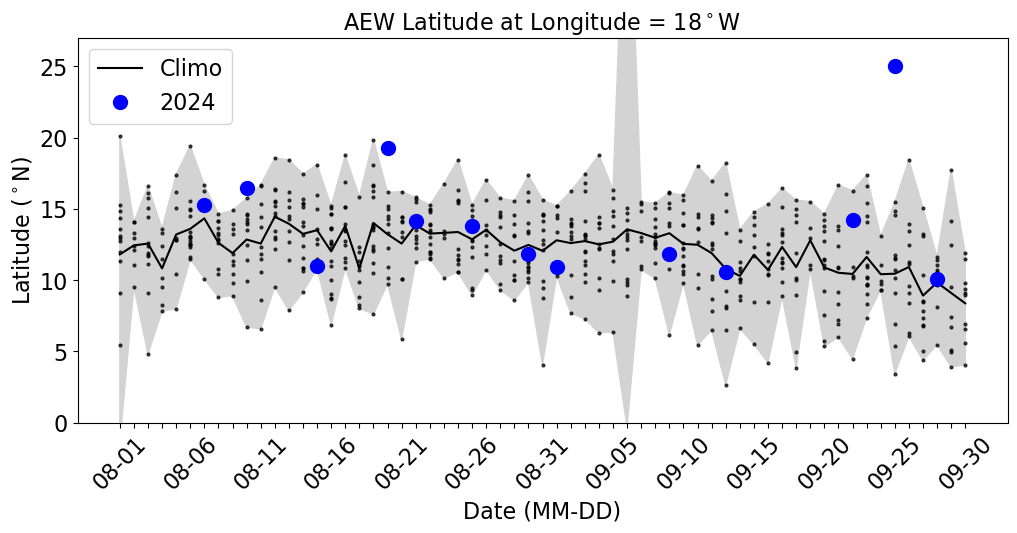

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
#make month day array from august 1 to september 30
date_range = pd.date_range(start="2024-08-01", end="2024-09-30")
date18_md_reg = [f"{d.month:02d}-{d.day:02d}" for d in date_range]

#Get dimensions
nAEW, ntimeAEW, nyears = AEWlat_subset.shape
lat18_reg_allyrs = np.full((np.size(date18_md_reg), nyears), np.nan)

# Loop over each year
for y, year in enumerate(years):

    AEW_lon = AEWlon_subset[:,:,y]    
    AEW_lat = AEWlat_subset[:,:,y]
    lat18 = np.full(nAEW, np.nan)  # Initialize array to hold latitudes at lon = -18
    lat18_reg = np.full(np.size(date18_md_reg), np.nan)
    date18 = [None] * nAEW   
    for i in range(nAEW):
        # Interpolate AEW latitude to a longitude of -18, mask over nan
        mask = ~np.isnan(AEW_lon[i, :]) & ~np.isnan(AEW_lat[i, :])
        lon_masked = AEW_lon[i, :][mask]
        lat_masked = AEW_lat[i, :][mask]
        dates_arr = np.array(dates_subset)
        dates_masked = dates_arr[:,y][mask]

        # Sort by longitude increasing
        sort_idx = np.argsort(lon_masked)
        lon_sorted = lon_masked[sort_idx]
        lat_sorted = lat_masked[sort_idx]
        date_sorted = dates_masked[sort_idx]
        
        #Check if there is data in lon_sorted
        if lon_sorted.size == 0:
            continue

        # Only interpolate if -18 is within the range
        if np.nanmin(lon_sorted) <= -18 <= np.nanmax(lon_sorted):
            lat18[i] = np.interp(-18, lon_sorted, lat_sorted)
            # Find the index closest to -18 for the date
            idx_closest = np.argmin(np.abs(lon_sorted + 18))
            # Convert cftime to datetime
            date_cftime = date_sorted[idx_closest]
            try:
                date18[i] = date_cftime.to_datetime()
            except AttributeError:
                date18[i] = pd.to_datetime(str(date_cftime))
        else:
            lat18[i] = np.nan
            date18[i] = None
                
    date18_md = [f"{d.month:02d}-{d.day:02d}" if d is not None else "" for d in date18]
    #fill lat18_reg
    for i, md in enumerate(date18_md):
        if md in date18_md_reg:
            lat18_reg[date18_md_reg.index(md)] = lat18[i]
    lat18_reg_allyrs[:,y] = lat18_reg
    ax.plot(date18_md_reg,lat18_reg, 'o', color='black', alpha = 0.7, markersize=2)

#climo mean
ax.plot(date18_md_reg,np.nanmean(lat18_reg_allyrs,axis=1), color='black', label='Climo')
#ax.plot(date18_md_reg,np.nanmin(lat18_reg_allyrs,axis=1), color='lightgray')
#ax.plot(date18_md_reg,np.nanmax(lat18_reg_allyrs,axis=1), color='lightgray')
ax.fill_between(date18_md_reg, np.nanmin(lat18_reg_allyrs,axis=1), np.nanmax(lat18_reg_allyrs,axis=1), color='lightgray')

# add 2024
ax.plot(date18_md_reg,lat18_2024_reg, 'o', color='blue', markersize=10,label='2024')

# plot attributes
ax.set_title('AEW Latitude at Longitude = 18$^\circ$W',fontsize=16)
ax.set_xlabel('Date (MM-DD)',fontsize=16)
ax.set_ylabel('Latitude ($^\circ$N)',fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(0,27)

xticks = np.arange(len(date18_md_reg))
xticklabels = [date18_md_reg[i] if i % 5 == 0 else "" for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45,fontsize=16)        
        